In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import seaborn as sns

In [39]:
columns = ['DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance', 'index']

encoding = ['OD']

minmax = ['PricePerPax']

# box_cox = ['PricePerPax', 'TravelDistanceKm']

# yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']


In [47]:
# Reading the csv
data = pd.read_csv('../raw_data/skyscanner_data_171223')

data['index'] = data.index

# Dropping NA data from specific columns
no_nan = data.dropna(subset=['OriginApt', 'DestinationApt', 'DurationMin', 'PricePerPax', 'DestinationCtry'])


# Only keeping ecoonomy flights
economy_flights = no_nan[(no_nan['PricePerPax'] > 0) & (no_nan['PricePerPax'] < 2000)]

# Removing weird numbers with negative distances
distance_makes_sense_flights = economy_flights[(economy_flights["TravelDistanceKm"]<= economy_flights["Total_Flight_Distance"]) &
                                               (economy_flights["Total_Flight_Distance"] <= 5*economy_flights["TravelDistanceKm"])]

#THIS SECTION IS A FIDDLE
# Here i am removing low volumne data
# precise_data = distance_makes_sense_flights[distance_makes_sense_flights['ODRedirects'] > 15].copy()


# Creating processed data
processed_data, scalers = all_preprocessing(distance_makes_sense_flights, columns, log_od_by_itredirects, 'log_od_by_itredirect', min_max_scaling=minmax)

/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [54]:
distance_makes_sense_flights[(distance_makes_sense_flights['PricePerPax'] > 96)& (distance_makes_sense_flights['PricePerPax'] < 99)]

,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,passengers,PricePerPax,ItineraryRedirects,ODRedirects,index,OD,total_layover_time,total_layover_time_ratio,extra_travel_distance,extra_travel_distance_ratio
91,TPE,TPE,TW,MNL,MNL,PH,63.0,1175.0,False,0.0,...,2.0,98.335000,2.0,76.0,91.0,TPEMNL,0.0,0.000000,0.0,1.00000
155,TPE,TPE,TW,ICN,SEL,KR,66.0,1464.0,False,0.0,...,28.0,98.456591,22.0,689.0,155.0,TPESEL,0.0,0.000000,0.0,1.00000
205,TUN,TUN,TN,BRU,BRU,BE,41.0,1627.0,False,0.0,...,20.0,98.182143,7.0,35.0,205.0,TUNBRU,0.0,0.000000,0.0,1.00000
212,TUN,TUN,TN,ORY,PAR,FR,11.0,1467.0,False,0.0,...,9.0,96.932857,7.0,248.0,212.0,TUNPAR,0.0,0.000000,0.0,1.00000
544,VCE,VCE,IT,CMN,CAS,MA,28.0,2169.0,False,0.0,...,8.0,98.801250,4.0,16.0,544.0,VCECAS,0.0,0.000000,0.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14097033,CRL,BRU,BE,PMI,PMI,ES,33.0,1220.0,False,0.0,...,19.0,97.275625,8.0,31.0,14097033.0,BRUPMI,0.0,0.000000,0.0,1.00000
14097073,BSB,BSB,BR,CWB,CWB,BR,11.0,1083.0,False,0.0,...,1.0,98.100000,1.0,34.0,14097073.0,BSBCWB,0.0,0.000000,0.0,1.00000
14097104,BSB,BSB,BR,GIG,RIO,BR,15.0,915.0,False,1.0,...,3.0,96.163333,3.0,245.0,14097104.0,BSBRIO,315.0,0.480916,2752.0,4.00765
14097146,BUD,BUD,HU,CPH,CPH,DK,13.0,1016.0,False,0.0,...,1.0,97.500000,1.0,42.0,14097146.0,BUDCPH,0.0,0.000000,0.0,1.00000


In [55]:
distance_makes_sense_flights[distance_makes_sense_flights['index'] == 14097073]

,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,passengers,PricePerPax,ItineraryRedirects,ODRedirects,index,OD,total_layover_time,total_layover_time_ratio,extra_travel_distance,extra_travel_distance_ratio
14097073,BSB,BSB,BR,CWB,CWB,BR,11.0,1083.0,False,0.0,...,1.0,98.1,1.0,34.0,14097073.0,BSBCWB,0.0,0.0,0.0,1.0


In [56]:
processed_data[processed_data['index'] == 14097073]

,DurationMin,PricePerPax,total_layover_time,extra_travel_distance_ratio,Total_Flight_Distance,index,log_od_by_itredirect
14097073,120.0,0.048779,0.0,1.0,1083.0,14097073.0,3.555348


In [48]:
distance_makes_sense_flights[distance_makes_sense_flights['index'] == 8704614]

,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,passengers,PricePerPax,ItineraryRedirects,ODRedirects,index,OD,total_layover_time,total_layover_time_ratio,extra_travel_distance,extra_travel_distance_ratio
8704614,GIG,RIO,BR,REC,REC,BR,1.0,1859.0,False,0.0,...,3.0,276.27,3.0,235.0,8704614.0,RIOREC,0.0,0.0,0.0,1.0


In [53]:
distance_makes_sense_flights[distance_makes_sense_flights['index'] == 4868777]

,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,passengers,PricePerPax,ItineraryRedirects,ODRedirects,index,OD,total_layover_time,total_layover_time_ratio,extra_travel_distance,extra_travel_distance_ratio
4868777,ORY,PAR,FR,AGP,AGP,ES,9.0,1451.0,False,0.0,...,2.0,75.865,2.0,122.0,4868777.0,PARAGP,0.0,0.0,0.0,1.0


In [50]:
processed_data[processed_data['index'] == 8704614]

,DurationMin,PricePerPax,total_layover_time,extra_travel_distance_ratio,Total_Flight_Distance,index,log_od_by_itredirect
8704614,175.0,0.13789,0.0,1.0,1859.0,8704614.0,16.391495


In [51]:
processed_data[processed_data['index'] == 4868777]

,DurationMin,PricePerPax,total_layover_time,extra_travel_distance_ratio,Total_Flight_Distance,index,log_od_by_itredirect
4868777,145.0,0.037658,0.0,1.0,1451.0,4868777.0,9.624369


<Axes: >

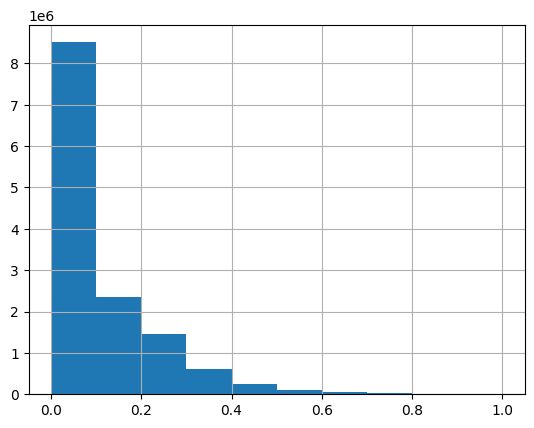

In [21]:
processed_data['PricePerPax'].hist()

In [4]:
data.columns, data.shape

(Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
        'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
        'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin', 'dayofweek',
        'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA',
        'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
        'Total_Flight_Distance', 'Total_Flight_Duration', 'passengers',
        'PricePerPax', 'ItineraryRedirects', 'ODRedirects'],
       dtype='object'),
 (14097280, 22))

In [5]:
clean_processed_data = processed_data.dropna(subset=['log_od_by_itredirect'])

In [6]:
# Graph for looking into high frequency targets
# clean_processed_data[clean_processed_data['log_od_by_itredirect'] < 40]['log_od_by_itredirect'].hist(figsize=(20,6), bins=40)

In [7]:
# randomly removing high frequency datapoints

less_than_18 = clean_processed_data[clean_processed_data['log_od_by_itredirect'] < 18].copy()
greater_than_eq_18 = clean_processed_data[clean_processed_data['log_od_by_itredirect'] >= 18].copy()

# less_than_18_sampled = less_than_18.sample(frac=0.5).copy()

smalled_training_set = pd.concat([less_than_18, greater_than_eq_18])

<Axes: >

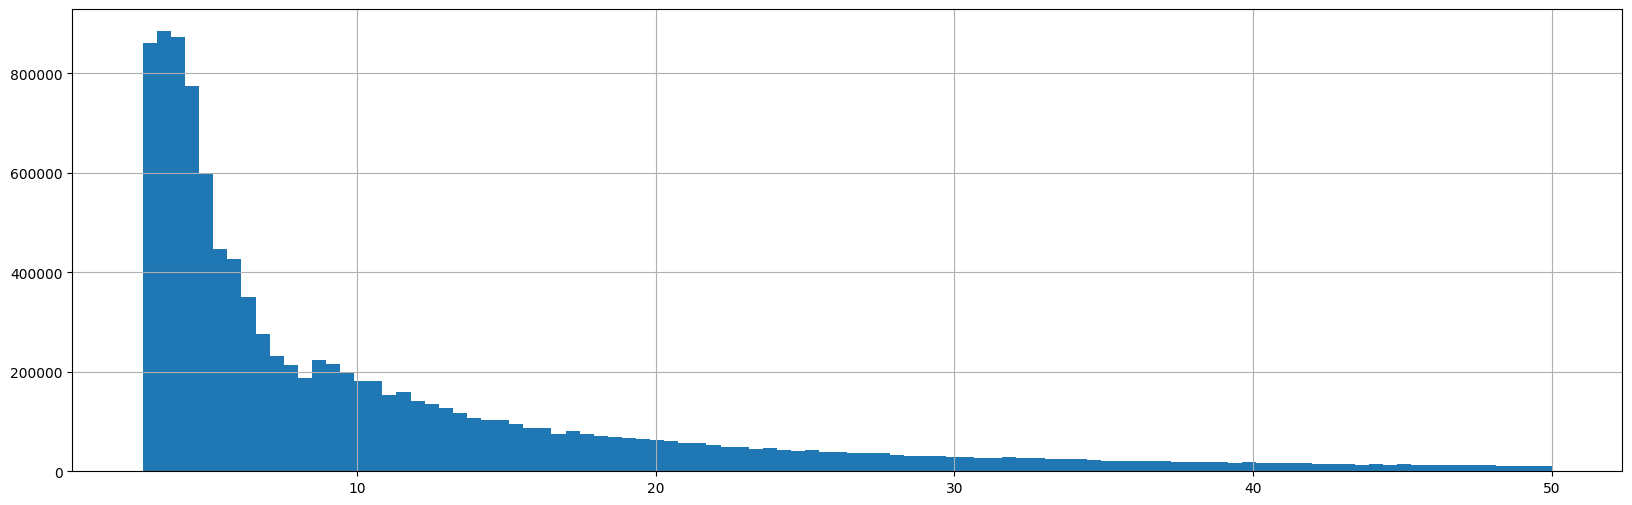

In [8]:
smalled_training_set[smalled_training_set['log_od_by_itredirect'] < 50]['log_od_by_itredirect'].hist(figsize=(20, 6), bins=100)

In [9]:
smalled_training_set['category'] = np.where(smalled_training_set['log_od_by_itredirect'] >= 18, 1, 0)

<Axes: >

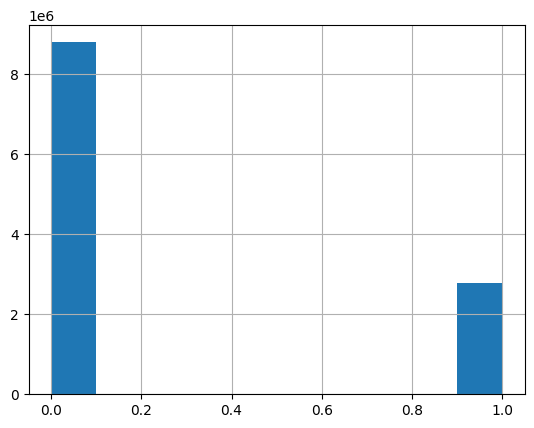

In [10]:
smalled_training_set['category'].hist()

In [11]:
testing_train = smalled_training_set.drop(columns=['log_od_by_itredirect']).copy()

In [12]:
# Adding dayofweek back to df

# original_data_subset_by_training_data = data.loc[smalled_training_set.index].copy()
# smalled_training_set['dayofweek'] = original_data_subset_by_training_data['dayofweek']

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(clean_processed_data.drop('lod_od_by_itredirect', axis=1),
#                                                     clean_processed_data['lod_od_by_itredirect'], test_size=0.2, random_state=42)

In [14]:
dohop_data = pd.read_csv('../raw_data/OptiFlyAI_testset.csv')
processed_dohop = process_new_data(original_data=data.loc[smalled_training_set.index], new_data=dohop_data, scalers=scalers,
                 columns_to_keep=columns)

/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:522: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['seg_0'][i] = listtt[0][:2]
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:522: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_data['seg_0'][i] = listtt[0][:2]
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['seg_1'][i] = listtt[1].strip()[:2]


In [15]:
# Adding dayofweek back to df

# dohop_data_subset_by_processed_data = dohop_data.loc[processed_dohop.index].copy()
# processed_dohop['dayofweek'] = dohop_data_subset_by_processed_data['dayofweek']

In [16]:
dohop_dropped_na = processed_dohop.dropna(subset=['total_layover_time', 'extra_travel_distance_ratio'])

In [17]:
dohop_dropped_na.isna().sum()

DurationMin                         0
PricePerPax                         0
total_layover_time                  0
extra_travel_distance_ratio         0
Total_Flight_Distance               0
bookings                       588125
dtype: int64

# Random forrest Classifiers

In [18]:
def evaluate_model_classifier(data, model):
    data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()

    # Create a new colummn bucketed into "booked" and "not-booked"
    data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
    booked_data = data[data["status"] == "booked"].copy()

    # Filter down the dataset to those rows which were not booked
    not_booked_data = data[data["status"] == "not-booked"].copy()

    # Check for the edge case and issue a warning, if it applies

    metrics = {"total_rows": data.shape[0],
               "TP": booked_data[booked_data["predicted_score"] == 1].shape[0],
               "FP": not_booked_data[not_booked_data["predicted_score"] == 1].shape[0],
               "TN": not_booked_data[not_booked_data["predicted_score"] == 0].shape[0],
               "FN": booked_data[booked_data["predicted_score"] == 0].shape[0],
               }

    return metrics, booked_data, not_booked_data

In [19]:
forrest = RandomForestClassifier(n_estimators=60, criterion="gini", max_depth=10, n_jobs=-1)

forrest.fit(testing_train.drop('category', axis=1), testing_train['category'])

RandomForestClassifier(max_depth=10, n_estimators=60, n_jobs=-1)

<Axes: >

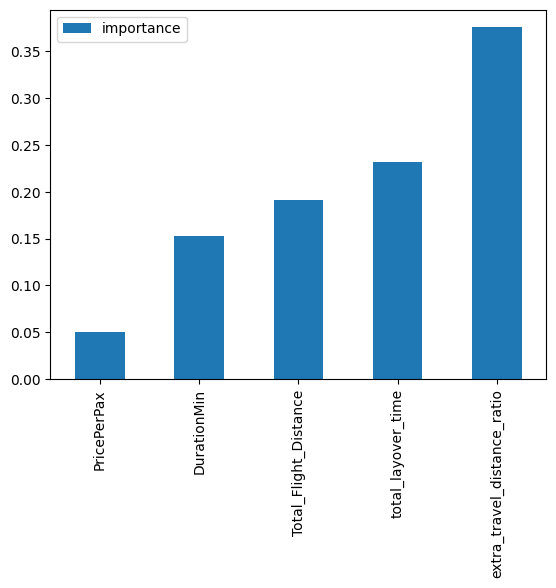

In [24]:
# Getting list of features
feats = testing_train.drop('category', axis=1).columns.to_list()

# Plotting importance
df = pd.DataFrame(index=feats)
df['importance'] = forrest.feature_importances_
df.sort_values('importance').plot(kind='bar')

In [25]:
met, booked, not_booked = evaluate_model_classifier(dohop_dropped_na, forrest)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- predicted_score
- status


In [22]:
not_booked.sort_values('predicted_score')

,DurationMin,PricePerPax,total_layover_time,extra_travel_distance_ratio,Total_Flight_Distance,bookings,predicted_score,status
7162,455.0,161.550670,280.0,2.771421,1091.103,NaN,0,not-booked
399572,428.0,178.385500,160.0,1.002307,2176.245,NaN,0,not-booked
399571,1185.0,273.871667,845.0,2.115465,3314.121,NaN,0,not-booked
399570,395.0,110.487641,240.0,2.492106,981.137,NaN,0,not-booked
399569,650.0,130.793403,485.0,1.046826,1241.515,NaN,0,not-booked
...,...,...,...,...,...,...,...,...
203367,504.0,229.427170,324.0,1.021486,1287.730,NaN,0,not-booked
203368,1355.0,347.721215,870.0,1.267431,5098.410,NaN,0,not-booked
203369,753.0,130.641197,561.0,1.279090,1485.994,NaN,0,not-booked
203363,340.0,92.033032,175.0,1.065472,1264.528,NaN,0,not-booked


In [23]:
booked.sort_values('bookings')

,DurationMin,PricePerPax,total_layover_time,extra_travel_distance_ratio,Total_Flight_Distance,bookings,predicted_score,status
3582,455.0,138.577279,235.0,1.476860,1894.417,1.0,0,booked
4776,1640.0,253.518795,1325.0,1.198220,3135.323,1.0,0,booked
4775,905.0,256.191934,510.0,1.008046,3929.088,1.0,0,booked
4774,1015.0,393.130198,150.0,1.145475,10156.985,1.0,0,booked
4773,1070.0,553.472137,130.0,1.025429,11975.342,1.0,0,booked
...,...,...,...,...,...,...,...,...
15,475.0,132.255729,205.0,1.552808,2310.742,4.0,0,booked
9,385.0,197.876926,150.0,1.189730,1913.709,4.0,0,booked
2,600.0,114.013625,310.0,1.310653,2796.943,5.0,0,booked
1,410.0,115.483231,210.0,1.854818,1714.360,5.0,0,booked


In [26]:
met

{'total_rows': 595207, 'TP': 0, 'FP': 0, 'TN': 588125, 'FN': 7082}

# Random forrest Regressors

In [16]:
def evaluate_model(data, model):
    data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()

    # Create a new colummn bucketed into "booked" and "not-booked"
    data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
    booked_data = data[data["status"] == "booked"].copy()

    # Filter down the dataset to those rows which were not booked
    not_booked_data = data[data["status"] == "not-booked"].copy()

    # Compute minimum score threshold for booked and not-booked data
    min_booked_score = data.loc[data["status"] == "booked", "predicted_score"].min()
    min_not_booked_score = data.loc[data["status"] == "not-booked", "predicted_score"].min()

    # Check for the edge case and issue a warning, if it applies
    if min_booked_score < min_not_booked_score:
        return "Edge case encountered: Min score of booked rows is lower than min score of not-booked rows."

    metrics = {"min_threshold": min_booked_score,
               "total_rows": data.shape[0],
               "TP": booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "FP": not_booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "TN": not_booked_data[data["predicted_score"] < min_booked_score].shape[0],
               "FN": booked_data[data["predicted_score"] < min_booked_score].shape[0],
               }

    return metrics

In [17]:
# Instantiating model
forrest = RandomForestRegressor(n_estimators=150, criterion="poisson", max_depth=25, n_jobs=-1, min_samples_split=3)

# Training model
forrest.fit(smalled_training_set.drop('log_od_by_itredirect', axis=1), smalled_training_set['log_od_by_itredirect'])

RandomForestRegressor(criterion='poisson', max_depth=21, n_estimators=120,
                      n_jobs=-1)

### Exploring feature importance

<Axes: >

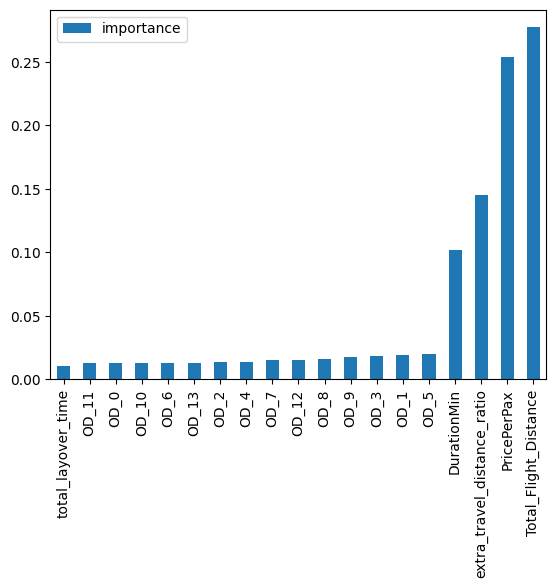

In [18]:
# Getting list of features
feats = smalled_training_set.drop('log_od_by_itredirect', axis=1).columns.to_list()

# Plotting importance
df = pd.DataFrame(index=feats)
df['importance'] = forrest.feature_importances_
df.sort_values('importance').plot(kind='bar')

In [19]:
evaluate_model(dohop_dropped_na, forrest)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:23: UserWarning: Boolean

{'min_threshold': 2.2222162759015993,
 'total_rows': 595207,
 'TP': 7082,
 'FP': 588092,
 'TN': 33,
 'FN': 0}

# Model results

### Results for Poisson Random Forrest with 120 trees, and 21 max depth

#### Trained on all data, with low target reduction

columns = ['DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance']

encoding = ['OD']

Target = lod_od_by_itredirect

- min_threshold': 2.2222162759015993,
- 'total_rows': 595207,
- 'TP': 7082,
- FP': 588092,
- 'TN': 33,
- 'FN': 0

Training time - 23 minutes

### Results for Poisson Random Forrest with 120 trees, and 21 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance']

encoding = ['OD']

Target = lod_od_by_itredirect

'Edge case encountered: Min score of booked rows is lower than min score of not-booked rows.'

Training time - 25 minutes

### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance_ratio']

Target = lod_od_by_itredirect

- 'min_threshold': 4.360915931874575,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588111,
- 'TN': 14,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 5.344674649929984,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587062,
- 'TN': 1063,
- 'FN': 0

Training time = 13 minutes


 ### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.672910392621909,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 586823,
- 'TN': 1302,
- 'FN': 0

Training time - 19 Minutes

### Results for Poisson Random Forrest with 60 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.575537392470289,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587598,
- 'TN': 527,
- 'FN': 0

Training time - 15 minutes

### Results for Poisson Random Forrest with 150 trees, and 12 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.185502636034341,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587532,
- 'TN': 593,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 80 trees, and 20 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.1303687347750593,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587909,
- 'TN': 216,
- 'FN': 0

Training time - 32 Minutes

### Results for Poisson Random Forrest with 80 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.573138342576451,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587159,
- 'TN': 966,
- 'FN': 0

Training time - 19 Minutes

### Results for Poisson Random Forrest with 100 trees, and 8 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 5.302893033067785,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588104,
- 'TN': 21,
- 'FN': 0

Training time - 20 Minutes

### Results for Poisson Random Forrest with 100 trees, and 15 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.836471876184013,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587586,
- 'TN': 539,
- 'FN': 0

Training time - 33 Minutes

 ### Results for Poisson Random Forrest with 200 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.687645660979575,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587021,
- 'TN': 1104,
- 'FN': 0

Training time - 31 Minutes

### Results for Poisson Random Forrest with 10 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']


- 'min_threshold': 0.3559356535380518,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588118,
- 'TN': 7,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 10 trees, and 25 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3980702486833349,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587975,
- 'TN': 150,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 15 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.4278422656407467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587982,
- 'TN': 143,
- 'FN': 0

Training time - 17 minutes

### Results for Poisson Random Forrest with 30 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3982078050924747,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588117,
- 'TN': 8,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 5 trees, and 30 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.37001877943373246,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587691,
- 'TN': 434,
- 'FN': 0

Training time - 6 Minutes

#### Training on all data

- 'min_threshold': 0.33475150098093887,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588101,
- 'TN': 24,
- 'FN': 0

 Training time - 7 minutes

### Results for Poisson Random Forrest with 7 trees, and 40 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3839483185231023,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587455,
- 'TN': 670,
- 'FN': 0

Training time - 9 minutes

#### Training on all data

- 'min_threshold': 0.3396465747051723,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588123,
- 'TN': 2,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 10 trees, and 50 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.35784383270600656,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588114,
- 'TN': 11,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 10 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.38201788753136257,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588032,
- 'TN': 93,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 15 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3933023326683685,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587957,
- 'TN': 168,
- 'FN': 0

Training time - 21 minutes


"Squared_error"
- min_threshold': 0.3944760162794704,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588066,
- 'TN': 59,
- 'FN': 0

### Results for Poisson Random Forrest with 15 trees, and 50 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3929733733862467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587980,
- 'TN': 145,
- 'FN': 0

Training time - 24 minutes
"squared_error"

- min_threshold': 0.39101792990309453,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588023,
- 'TN': 102,
- 'FN': 0

### Results for Poisson Random Forrest with 20 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.40042538000947714,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588033,
- 'TN': 92,
- 'FN': 0

Training time - 29 minutes